In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.patches as patches

from physhapes.plotting import *
from physhapes.mcmc import load_mcmc_results

# Visualize results


In [5]:
burnin_percent = 0.3
sim_path = "exp_2_sigma=0.7_alpha=0.025_dt=0.05/seed=930739538"  # Change to your experiment path
mcmc_path = sim_path + "/mcmc/id=848612469"
results_path = mcmc_path + "/results_*.pkl"  # Adjust pattern as needed
save_path = mcmc_path + "/plots"
os.makedirs(save_path, exist_ok=True)

chain_results = load_mcmc_results(results_path)
param_names = ["sigma", "alpha"]  # Replace with your actual parameter names
len(chain_results)

0

In [ ]:
plot_log_posterior(chain_results, burnin_percent, save_path=save_path + f'/log_posterior_burnin_percent={burnin_percent}.png')

In [ ]:
print([np.mean(result['acceptsigma']) for result in chain_results if result is not None])

In [ ]:
[np.mean(result['acceptalpha']) for result in chain_results if result is not None]

In [ ]:
[np.mean(result['acceptpath']) for result in chain_results if result is not None]

In [ ]:
plot_parameter_traces(chain_results, param_names, burnin_percent, savepath=save_path + f'/parameter_traces_burnin_percent={burnin_percent}.png')

In [ ]:
burnin_end = int(chain_results[0]['sigma'].shape[0] * burnin_percent)
print(np.mean([chain_results[i]['sigma'][burnin_end:] for i in range(len(chain_results)) if chain_results[i] is not None]))
print(np.mean([chain_results[i]['alpha'][burnin_end:] for i in range(len(chain_results)) if chain_results[i] is not None]))

In [ ]:
chain_results[0]['settings']

In [ ]:
diagnostics = compute_diagnostics(chain_results, burnin_percent)

In [ ]:
plot_traces(chain_results, burnin_percent, node_idx=[0, 1, 2, 6], save_path=save_path, diagnostics=diagnostics)

In [ ]:
plot_samples_from_posterior(chain_results, burnin_percent=0.5, node_idx=[0, 1, 2, 6], sample_every=50, savepath=save_path, true_values=None)

# Look at posterior covariation

In [ ]:
# visualize landmarks with labels 
flat_true_tree = np.genfromtxt(sim_path + "/flat_true_tree.csv", delimiter=',')   
plt.plot(flat_true_tree[0][0::2], flat_true_tree[0][1::2], '.', color='black', linewidth=2, label='true shape')
n = list(range(len(flat_true_tree[0][::2])))
for i, txt in enumerate(n):
    plt.annotate(txt, (flat_true_tree[0][::2][i], flat_true_tree[0][1::2][i]))

In [ ]:
print(list(range(0, 40, 2)))
list(range(1, 40, 2))

In [ ]:
def gaussian_kde_contour(x, y, levels=[0.05]):
    
    # Create kernel density estimate
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method="silverman")

    # Create a grid to evaluate the KDE
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= 0.1 * x_range
    x_max += 0.1 * x_range
    y_min -= 0.1 * y_range
    y_max += 0.1 * y_range
    x_grid, y_grid = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
    positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

    # Evaluate the KDE at the grid positions
    z = kde(positions).reshape(x_grid.shape)

    # Sort density values and find thresholds for specified levels
    z_flat = z.flatten()
    z_sorted = np.sort(z_flat)
    cumsum = np.cumsum(z_sorted)
    cumsum /= cumsum[-1]  # Normalize


    threshold_idx = np.searchsorted(cumsum, levels)
    threshold = z_sorted[threshold_idx]

    return x_grid, y_grid, z, threshold

def plot_bivariate_gaussian_contour(x, y, ax=None, alpha=0.1, point_color='steelblue', 
                                   contour_color='black', confidence=0.95):
    """
    Fit a bivariate Gaussian to data and plot the confidence contour.
    
    Parameters:
    -----------
    x, y : array-like
        Input data coordinates
    ax : matplotlib.axes, optional
        Axes to plot on
    alpha : float
        Transparency for scatter points
    point_color : str
        Color for scatter points
    contour_color : str
        Color for contour line
    confidence : float
        Confidence level (0.95 = 95%)
    """
    # Create figure if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the data points
    ax.plot(x, y, '.', color=point_color, alpha=alpha)
    
    # Fit a bivariate Gaussian (calculate mean and covariance)
    data = np.vstack([x, y]).T
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    
    # Create grid for contour
    x_range = max(x) - min(x)
    y_range = max(y) - min(y)
    margin = 0.2
    x_grid = np.linspace(min(x) - margin*x_range, max(x) + margin*x_range, 100)
    y_grid = np.linspace(min(y) - margin*y_range, max(y) + margin*y_range, 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    pos = np.dstack((X, Y))
    
    # Create the bivariate normal distribution
    from scipy.stats import multivariate_normal
    rv = multivariate_normal(mean=mean, cov=cov)
    Z = rv.pdf(pos)
    
    # For a bivariate Gaussian, 95% confidence corresponds to chi2(df=2) = 5.991
    # Mahalanobis distance: (x-μ)ᵀΣ⁻¹(x-μ) = 5.991
    # We find PDF value that corresponds to this contour
    chi2_val = 5.991  # 95% confidence for 2D
    pdf_threshold = rv.pdf(mean) * np.exp(-0.5 * chi2_val)
    
    # Plot the contour
    contour = ax.contour(X, Y, Z, levels=[pdf_threshold], 
                         colors=contour_color, linewidths=1.5, linestyles='--')
    
    return ax

In [ ]:
nodeP = [0, 1, 2, 6]
nodeR = [6,7,8,9]
nidx = 0
dim = [0, 2, 22]

# nchain x mcmc iter x nnodes x ndim
burnin_end = int(chain_results[0]['trees'].shape[0] * burnin_percent)
all_posterior_samples = np.array([chain_results[i]['trees'][burnin_end:,:,:] for i in range(len(chain_results)) if chain_results[i] is not None])
print(all_posterior_samples[0].shape)
l0x = all_posterior_samples[:,:,nodeP[nidx],dim[0]].flatten()
l1x = all_posterior_samples[:,:,nodeP[nidx],dim[1]].flatten()
l12x = all_posterior_samples[:,:,nodeP[nidx],dim[2]].flatten()

# load confidence intervals from folder 
conf_dim0 = pd.read_csv(sim_path + f"/fastAnc/95%_conf_trait{dim[0]+1}.csv", header=0, index_col=0)
conf_dim1 = pd.read_csv(sim_path + f"/fastAnc/95%_conf_trait{dim[1]+1}.csv", header=0, index_col=0)
conf_dim2 = pd.read_csv(sim_path + f"/fastAnc/95%_conf_trait{dim[2]+1}.csv", header=0, index_col=0)

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), sharex=True, sharey=False)
plt.subplots_adjust(wspace=0.2, hspace=0.15)
axes = axes.flatten()

axes[0].set_xlabel('Landmark 0 (x-coordinate)')
axes[0].set_ylabel('Landmark 1 (x-coordinate)')
axes[0].set_title('Brownian motion model', size=13)
x_min, x_max = conf_dim0.iloc[nidx, 0], conf_dim0.iloc[nidx, 1]; y_min, y_max = conf_dim1.iloc[nidx, 0], conf_dim1.iloc[nidx, 1]    
padding = 0.8
x_range = x_max - x_min
y_range = y_max - y_min
axes[0].set_xlim(x_min - padding * x_range, x_max + padding * x_range)
axes[0].set_ylim(y_min - padding * y_range, y_max + padding * y_range)
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                         linewidth=1, 
                         edgecolor='black', 
                         facecolor='steelblue', 
                         alpha=0.5)
axes[0].add_patch(rect)
#axes[0].text(x_max, y_min, "Region of interest", 
#             fontsize=9, 
#             color='black', 
#             va='bottom')
axes[1].set_xlim(x_min - padding * x_range, x_max + padding * x_range)
axes[1].set_ylim(y_min - padding * y_range, y_max + padding * y_range)
axes[1].set_xlabel('Landmark 0 (x-coordinate)')
axes[1].set_ylabel('Landmark 1 (x-coordinate)')
axes[1].set_title('Shape aware model', size=13)
#axes[1].plot(l0x, l1x, '.', color='steelblue', alpha=0.1)
#x_grid, y_grid, z, threshold = gaussian_kde_contour(l0x, l1x, levels=[0.05])
#contour = axes[1].contour(x_grid, y_grid, z, levels=[threshold], 
#                         colors='black', linewidths=1)
plot_bivariate_gaussian_contour(l0x, l1x, ax=axes[1], alpha=0.1, 
                               point_color='steelblue', contour_color='red')
#axes[1].clabel(contour, inline=True, fontsize=10, fmt='%.2f')

padding=0.8
axes[2].set_xlabel('Landmark 0 (x-coordinate)')
axes[2].set_ylabel('Landmark 12 (x-coordinate)')
x_min, x_max = conf_dim0.iloc[nidx, 0], conf_dim0.iloc[nidx, 1]; y_min, y_max = conf_dim2.iloc[nidx, 0], conf_dim2.iloc[nidx, 1]
axes[2].set_xlim(x_min - padding * x_range, x_max + padding * x_range)
axes[2].set_ylim(y_min - padding * y_range, y_max + padding * y_range)
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                         linewidth=1, 
                         edgecolor='black', 
                         facecolor='steelblue', 
                         alpha=.5)
axes[2].add_patch(rect)
axes[3].set_xlim(x_min - padding * x_range, x_max + padding * x_range)
axes[3].set_ylim(y_min - padding * y_range, y_max + padding * y_range)
axes[3].set_xlabel('Landmark 0 (x-coordinate)')
axes[3].set_ylabel('Landmark 12 (x-coordinate)')
axes[3].plot(l0x, l12x, '.', color='steelblue', alpha=0.1)
#x_grid, y_grid, z, threshold = gaussian_kde_contour(l0x, l12x, levels=[0.05])
#contour = axes[3].contour(x_grid, y_grid, z, levels=[threshold], 
#                         colors='black', linewidths=1)
plot_bivariate_gaussian_contour(l0x, l12x, ax=axes[3], alpha=0.1, 
                               point_color='steelblue', contour_color='red')
plt.savefig(save_path+"/posterior_covariation_nidx={nidx}.pdf")

# Visualize inferred posterior 

In [6]:
import os
import pandas as pd
from glob import glob

def read_all_confidence_intervals(directory):
    """
    Read all CSV files starting with '95%' in the specified directory.
    
    Parameters:
    -----------
    directory : str
        Path to the directory containing the CSV files
        
    Returns:
    --------
    dict
        Dictionary with filenames as keys and pandas DataFrames as values
    """
    # Find all matching files
    pattern = os.path.join(directory, "95%*.csv")
    files = glob(pattern)
    
    if not files:
        print(f"No files matching '95%*.csv' found in {directory}")
        return {}
    
    # Read each file into a dictionary
    result = {}
    for file_path in files:
        file_name = os.path.basename(file_path)
        try:
            df = pd.read_csv(file_path, header=0, index_col=0)
            result[file_name] = df
            print(f"Successfully loaded: {file_name}")
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
    
    return result

# Example usage:
confidence_intervals = read_all_confidence_intervals(sim_path + "/fastAnc/")

# Access individual files:
# trait1_data = confidence_intervals["95%_conf_trait1.csv"]

Successfully loaded: 95%_conf_trait12.csv
Successfully loaded: 95%_conf_trait13.csv
Successfully loaded: 95%_conf_trait39.csv
Successfully loaded: 95%_conf_trait11.csv
Successfully loaded: 95%_conf_trait10.csv
Successfully loaded: 95%_conf_trait38.csv
Successfully loaded: 95%_conf_trait14.csv
Successfully loaded: 95%_conf_trait28.csv
Successfully loaded: 95%_conf_trait29.csv
Successfully loaded: 95%_conf_trait15.csv
Successfully loaded: 95%_conf_trait17.csv
Successfully loaded: 95%_conf_trait16.csv
Successfully loaded: 95%_conf_trait9.csv
Successfully loaded: 95%_conf_trait8.csv
Successfully loaded: 95%_conf_trait6.csv
Successfully loaded: 95%_conf_trait7.csv
Successfully loaded: 95%_conf_trait5.csv
Successfully loaded: 95%_conf_trait4.csv
Successfully loaded: 95%_conf_trait1.csv
Successfully loaded: 95%_conf_trait3.csv
Successfully loaded: 95%_conf_trait40.csv
Successfully loaded: 95%_conf_trait2.csv
Successfully loaded: 95%_conf_trait27.csv
Successfully loaded: 95%_conf_trait33.csv
S

In [7]:
fastAnc_recon= pd.read_csv(sim_path + f"/fastAnc/fastAnc_recon.csv", delimiter=',', header=0, index_col=0)
# read confidence intervals 
x_min, x_max = confidence_intervals['95%_conf_trait1.csv'].iloc[0,:]
y_min, y_max = confidence_intervals['95%_conf_trait2.csv'].iloc[0,:]

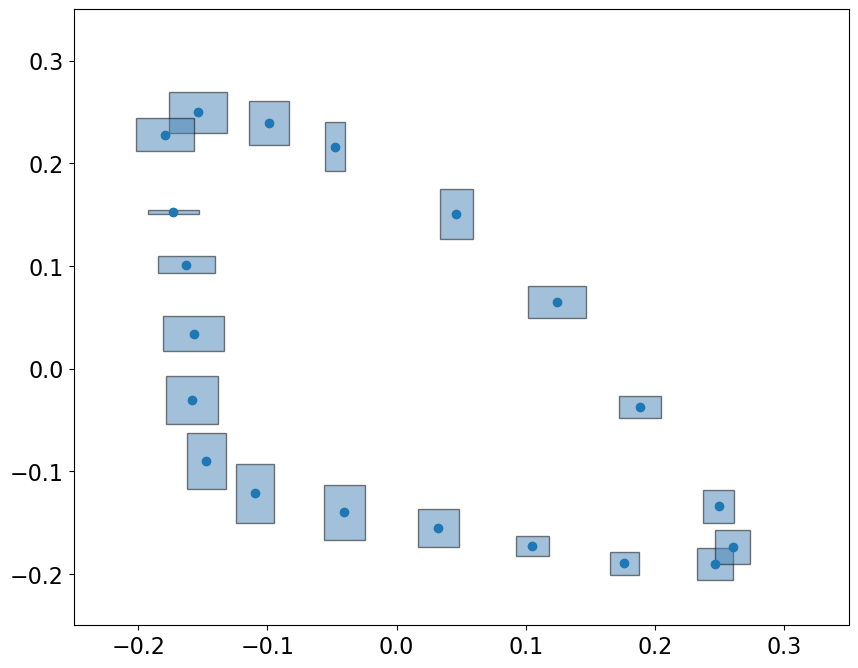

In [11]:
# plot reconstructions
fig, ax = plt.subplots(figsize=(10, 8))
node = 0
xlim_min = -0.25; xlim_max = 0.35
ylim_min = -0.25; ylim_max = 0.35
ax.plot(fastAnc_recon.iloc[0::2,node], fastAnc_recon.iloc[1::2,node], 'o')
ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)
# add confidence intervals as rectangles
for i in range(0, fastAnc_recon.shape[0], 2):
    x_min, x_max = confidence_intervals[f'95%_conf_trait{i+1}.csv'].iloc[node,:]
    y_min, y_max = confidence_intervals[f'95%_conf_trait{i+2}.csv'].iloc[node,:]
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                         linewidth=1, 
                         edgecolor='black', 
                         facecolor='steelblue', 
                         alpha=.5)  
    ax.add_patch(rect)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig(sim_path+f"/fastAnc_recon_with_conf_intervals_nidx={node}.pdf")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sele_node = all_posterior_samples[:,:,node,:].reshape(-1,all_posterior_samples.shape[3])
[ax.plot(sele_node[i,0::2], sele_node[i,1::2], '--o',  alpha=0.1, color='steelblue') for i in range(0, sele_node.shape[0], 50)]
ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sele_node = all_posterior_samples[:,:,node,:].reshape(-1,all_posterior_samples.shape[3])
[ax.plot(sele_node[i,22:29:2], sele_node[i,23:30:2], '--o',  alpha=0.1, color='steelblue') for i in range(0, sele_node.shape[0], 50)]


In [ ]:
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt

# Create a figure for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Get all samples
sele_node = all_posterior_samples[:,:,node,:].reshape(-1, all_posterior_samples.shape[3])

# Calculate distances between landmarks 12 and 13 for each sample
landmark12_13_distances = []
for i in range(0, sele_node.shape[0]):
    # Extract coordinates for landmark 12 (indices 24, 25)
    landmark12_x = sele_node[i, 24]
    landmark12_y = sele_node[i, 25]
    
    # Extract coordinates for landmark 13 (indices 26, 27)
    landmark13_x = sele_node[i, 26]
    landmark13_y = sele_node[i, 27]
    
    # Compute Euclidean distance
    dist = np.sqrt((landmark12_x - landmark13_x)**2 + (landmark12_y - landmark13_y)**2)
    landmark12_13_distances.append(dist)

# Plot histogram of the distances
ax.hist(landmark12_13_distances, bins=30, alpha=0.7, color='steelblue')
ax.set_xlabel('Distance Between Landmarks 12 and 13')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Distances Between Landmarks 12 and 13')

# Add statistics to the plot
mean_dist = np.mean(landmark12_13_distances)
median_dist = np.median(landmark12_13_distances)
min_dist = np.min(landmark12_13_distances)
max_dist = np.max(landmark12_13_distances)

# Add vertical line at mean
ax.axvline(x=mean_dist, color='red', linestyle='-', 
          label=f'Mean: {mean_dist:.4f}')

# Add vertical line at median
ax.axvline(x=median_dist, color='green', linestyle='--', 
          label=f'Median: {median_dist:.4f}')

# Add text with statistics
stats_text = (f"Min: {min_dist:.4f}\nMax: {max_dist:.4f}\n"
              f"Mean: {mean_dist:.4f}\nMedian: {median_dist:.4f}")
ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, 
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.legend()
plt.tight_layout()
plt.savefig(save_path + "/landmark12_13_distance_distribution.pdf")
plt.show()

# Print basic statistics
print(f"Distance between landmarks 12 and 13:")
print(f"Mean: {mean_dist:.4f}")
print(f"Median: {median_dist:.4f}")
print(f"Min: {min_dist:.4f}")
print(f"Max: {max_dist:.4f}")
print(f"Standard deviation: {np.std(landmark12_13_distances):.4f}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
node = 0
xlim_min = -0.35; xlim_max = 0.35
ylim_min = -0.25; ylim_max = 0.25

# Plot 1: Original plot
axes[0].plot(fastAnc_recon.iloc[0::2, node], fastAnc_recon.iloc[1::2, node], 'o')
axes[0].set_xlim(xlim_min, xlim_max)
axes[0].set_ylim(ylim_min, ylim_max)

# Add confidence intervals as rectangles to the original plot
for i in range(0, fastAnc_recon.shape[0], 2):
    x_min, x_max = confidence_intervals[f'95%_conf_trait{i+1}.csv'].iloc[node, :]
    y_min, y_max = confidence_intervals[f'95%_conf_trait{i+2}.csv'].iloc[node, :]
    rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=1,
        edgecolor='black',
        facecolor='steelblue',
        alpha=0.5
    )
    axes[0].add_patch(rect)

axes[0].set_title('Original Landmarks and Confidence Intervals')
axes[0].set_xlabel('X-coordinate')
axes[0].set_ylabel('Y-coordinate')
axes[0].set_aspect('equal')
axes[0].grid(True, linestyle='--', alpha=0.3)

# Plot 2: Rotated plot
# Rotate landmarks 45 degrees clockwise
angle_rad = np.radians(-45)  # negative for clockwise
rotation_matrix = np.array([
    [np.cos(angle_rad), -np.sin(angle_rad)],
    [np.sin(angle_rad), np.cos(angle_rad)]
])

# Rotate landmarks and plot
landmark_coords = np.column_stack((fastAnc_recon.iloc[0::2, node], fastAnc_recon.iloc[1::2, node]))
rotated_landmarks = np.dot(landmark_coords, rotation_matrix.T)
axes[1].plot(rotated_landmarks[:, 0], rotated_landmarks[:, 1], 'o')

# Set the plot limits
axes[1].set_xlim(xlim_min, xlim_max)
axes[1].set_ylim(ylim_min, ylim_max)

# Add rotated confidence intervals as polygons
for i in range(0, fastAnc_recon.shape[0], 2):
    # Get original confidence intervals
    x_min, x_max = confidence_intervals[f'95%_conf_trait{i+1}.csv'].iloc[node, :]
    y_min, y_max = confidence_intervals[f'95%_conf_trait{i+2}.csv'].iloc[node, :]
    
    # Calculate the four corners of the rectangle
    corners = np.array([
        [x_min, y_min],  # Bottom-left
        [x_max, y_min],  # Bottom-right
        [x_max, y_max],  # Top-right
        [x_min, y_max],  # Top-left
    ])
    
    # Rotate the corners
    rotated_corners = np.dot(corners, rotation_matrix.T)
    
    # Create a polygon patch with the rotated corners
    poly = patches.Polygon(
        rotated_corners,
        closed=True,
        linewidth=1,
        edgecolor='black',
        facecolor='steelblue',
        alpha=0.5
    )
    
    # Add the polygon to the plot
    axes[1].add_patch(poly)

axes[1].set_title('Rotated Landmarks and Confidence Intervals (45° Clockwise)')
axes[1].set_xlabel('X-coordinate')
axes[1].set_ylabel('Y-coordinate')
axes[1].set_aspect('equal')
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(save_path + "/original_vs_rotated_landmarks.pdf")
plt.show()